In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Functional Connectivity/'

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import copy


from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 


#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


# GENERATE + LOAD CSV FILE OF IMAGES:

In [3]:
# GENERATE + LOAD CSV FILE OF IMAGES:
from learning_functions import generate_data, load_data
generate_data()
inputs,onehot_outputs,sample_num,targets=load_data()
target_letters=['z','v','n']

# RUN LINEAR CLASSIFICATION

Created on Thu May 27 00:36:08 2021

@author: gnate

### TARGETS: 0 - 'z', 1 - 'v', 2 - 'n'

X = 9x30, y = 1x30

In [586]:
# plt.imshow(letters.values[rnd][:-1].reshape(3,3)) 
# print('Target Letter: ' + target_letters[int(letters.values[rnd][-1])])

In [6]:
# Generate inverse of input matrix
inv_inputs = np.linalg.pinv(inputs)

# Linear solve for inputs * W = onehot_outputs
W = np.zeros((10,3))
W = np.matmul(inv_inputs, onehot_outputs)
print("Weight matrix from linear solve - \n", W[:9,:])
print("Biases of output nodes - \n", W[9,:])

# Generate scatter plot of predicted outputs from linear solve 
predicted_outputs = np.matmul(inputs, W)
#print("\n Output predictions using linear solve - \n", predicted_outputs)

# Calculate prediction accuracy
accuracy = 0
for i in range(0,sample_num):
    if np.argmax(predicted_outputs[i]) == targets[i]:
        accuracy = accuracy + 1
print('Prediction accuracy -', accuracy/sample_num)

Weight matrix from linear solve - 
 [[ 0.0331142  -0.00779158 -0.02532262]
 [ 0.43438033 -0.25906988 -0.17531045]
 [ 0.0331142  -0.00779158 -0.02532262]
 [-0.19478938 -0.11102995  0.30581933]
 [ 0.0331142  -0.00779158 -0.02532262]
 [-0.19478938 -0.11102995  0.30581933]
 [ 0.27270514 -0.3778914   0.10518627]
 [ 0.19478938  0.11102995 -0.30581933]
 [ 0.27270514 -0.3778914   0.10518627]]
Biases of output nodes - 
 [-0.24129535  0.93912832  0.30216703]
Prediction accuracy - 1.0


<IPython.core.display.Javascript object>


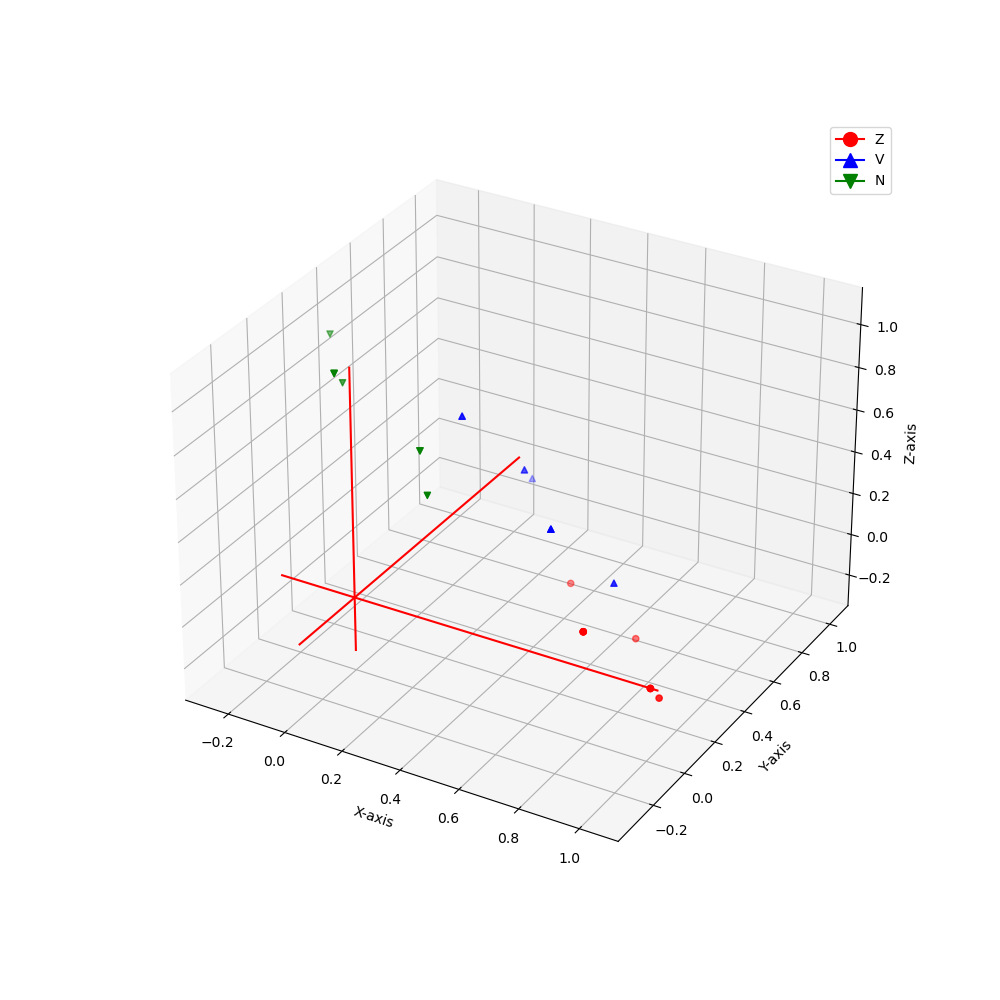

In [7]:
# Plot figures 
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, low, high in [('r', 'o', 0, 10), ('b', '^', 10, 20), ('g', 'v', 20, sample_num)]:
    xdata = predicted_outputs[low:high,0]
    ydata = predicted_outputs[low:high,1]
    zdata = predicted_outputs[low:high,2]
    ax.scatter(xdata, ydata, zdata, c = c, marker = m);
    
# Make simple, bare axis lines through space:
xAxisLine = ((min(predicted_outputs[:,0]), max(predicted_outputs[:,0])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(predicted_outputs[:,1]), max(predicted_outputs[:,1])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(predicted_outputs[:,2]), max(predicted_outputs[:,2])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

# Set axes labels and figure legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

red_point =  mlines.Line2D([], [], color='red', marker='o', 
                          markersize=10, label='Z')
blue_point = mlines.Line2D([], [], color='blue', marker='^', 
                           markersize=10, label='V')
green_point = mlines.Line2D([], [], color='green', marker='v', 
                           markersize=10, label='N')
plt.legend(handles=[red_point, blue_point, green_point])

plt.show()

# Generate rotating gif - Uncomment to generate the gif in current dir
# angle = 3
# ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=20)
# ani.save('predicted_outputs.gif', writer=animation.PillowWriter(fps=10))

# Test with some input
#rnd = np.random.randint(0,29)
#print("Predicted output -", test_output)
#actual_output = create_single_target(targets[rnd])
#print("Actual output -", actual_output)

# Repeat with Nanowire Network:

### Set up network 

In [4]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph

In [5]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [6]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

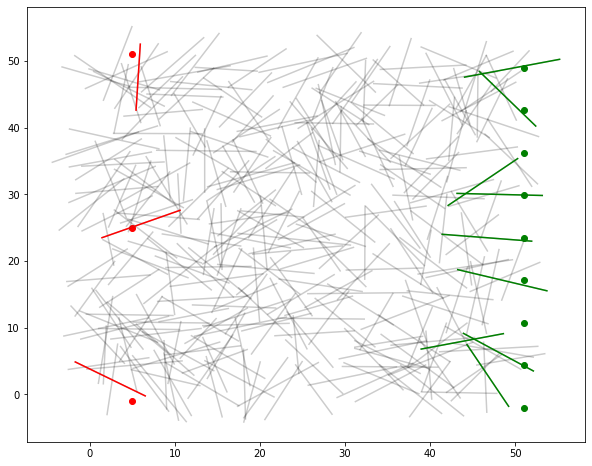

In [7]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*5#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(-1,51,numDrains)#(50,100,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9


#IN A LINE:
ex=np.ones(numSources)*51#95
ey=np.linspace(-2,49,numSources)#(35,100,numSources)
#IN A 3X3 GRID:
# middleNWx=int(connectivity.length_x/2)+1
# middleNWy=int(connectivity.length_y/2)-1
# distBwElecs=10
# ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
# ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [8]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))

OG Sources:[183 322 194  74 145 317 196 342 141]
OG Drains:[296 249 339]


In [9]:
#MANUAL SOURCES DRAINS IF THERE'S OVERLAP
elecSource=[23,320,26,74,145,317,129,247,141] #elecSource=[39,253,155,33,271,25,185,163,256]
elecDrain=[296,249,25]#elecDrain=[306,317,53]

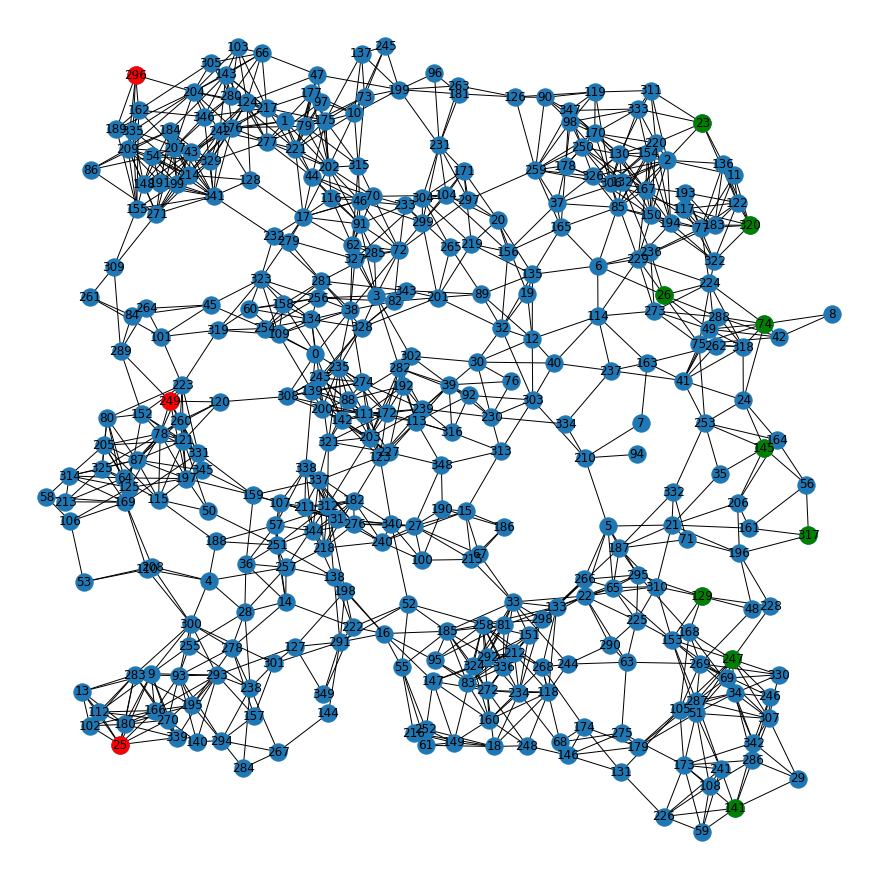

In [10]:
#PLOT GRAPH REPRESENTATION:
plt.figure(figsize=(12,12))
pos=nx.kamada_kawai_layout(nx.from_numpy_array(connectivity.adj_matrix))
nx.draw(nx.from_numpy_array(connectivity.adj_matrix),pos=pos,with_labels=True)
nx.draw_networkx_nodes(elecSource,node_color='g',pos=pos)
nx.draw_networkx_nodes(elecDrain,node_color='r',pos=pos)

### Define Functions For Equi Prop (move to learning_functions.py after finalising)s

In [11]:
# #VISUALISE NETWORK STATE
# def draw_network_state(connectivity,nwState):
#     adjMat=connectivity.adj_matrix
#     graph=nx.from_numpy_array(adjMat)
#     OGgraph=graph.copy()
#     pos=nx.kamada_kawai_layout(OGgraph)
#     numWires=graph.number_of_nodes()
#     edgeList=np.array(list(graph.edges()))
#     weightedSubGraph=getWeightedGraph(edgeList,numWires,nwState)
#     minWeights=-1e-5 #currents
#     maxWeights=1e-5 #currents
    
#     #draw network
#     %matplotlib inline
#     f,ax=plt.subplots(figsize=(10,6))
#     G=weightedSubGraph
#     edge_weights=nx.get_edge_attributes(G,'weight')
# #     G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-5)) 
#     edges=G.edges()
#     weights=[G[u][v]['weight'] for u,v in edges]

#     #draw OG graph
#     pos=nx.kamada_kawai_layout(OGgraph)
#     h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
#     h.set_zorder(1)

#     h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.bwr,edge_vmin=minWeights,edge_vmax=maxWeights)
# #     if h2:
# #         h2.set_norm(clrs.SymLogNorm(10))
# #         h2.set_zorder(3)
#     #             if j == 10 and i == 6:
#     #                 plt.colorbar(h2)
#     nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
#     nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=120,node_shape ='*',ax=ax)
#     plt.colorbar(h2,label='current',ax=ax)
#     plt.show()

In [12]:
#This function sets up the stimuli for simulations for the Associative Learning part of training
def setupStimulusAL(training_stimulus,currInput,run_time=2,onAmp=1,signalType='DC'):

    for i in range(len(drain_pool)):
        if i == targetClass:
            training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))
            
    #Sources
    for i in range(len(currInput)):
        if currInput[i]>0:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else: #non-active sources are changed to 0.005 instead of 0, to reduce sink behaviour between sources
#             training_stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))

    return training_stimulus

In [13]:
#This function sets up the stimuli for simulations. 
def setupStimulus(training_stimulus,currInput,run_time=2,onAmp=1,signalType='DC'):

    for i in range(num_drain_training):
        training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))
        
    #Sources
    for i in range(len(currInput)):
        if currInput[i]>0:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else: #non-active sources are changed to 0.005 instead of 0, to reduce sink behaviour between sources
#             training_stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))

    return training_stimulus

In [14]:
#This function sets up the stimuli for the testing part of the simulation. 
def setupSourcesOnly(stim,currInput,onAmp=1,run_time=2,signalType='DC'):
    #Sources
    stimulus=copy.deepcopy(stim)
    for i in range(len(currInput)):
        if currInput[i]>0:
            stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp*currInput[i],T=run_time,dt=dt)))
#         else:
#             stimulus.append((stimulus__(biasType=signalType,onAmp=0.01,T=run_time,dt=dt)))
    return stimulus

In [15]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getNWState(training_stimulus,state,drains,sources,run_time=2):
    eles = np.append(drains, sources) #all drains
#     if len(eles) == num_drain_training + num_source_training:
    training_sim = runSim(connectivity, stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=True)
                       #criticalFlux=0.01)  
    JS1 = getJunctionState(training_sim, -1) #save state
#     else: 
#         print('Bless you Joel :)')
    return training_sim,JS1

In [16]:
#This function calculates the conductance read out at each drain electrode, 
#which we use to determine if the target threshold for each electrode is met

def calcOutputs(sim2,all_drains):
    
    cc = np.zeros(len(all_drains))
    volt = np.zeros(len(all_drains))

#     for i, d in enumerate(all_drains):
#         a = wireCurrentTimeSeries(sim1, d)
#         b = wireCurrentTimeSeries(sim2, d)
#         print(a.shape,b.shape)
#         cc[i] = np.dot(a.reshape(-1),b.reshape(-1))

#     cc=(cc-minval)/(maxval-minval)
#       return cc

# ALTERNATIVE METHOD SUGGESTED BY JOEL


#Index network state:
    #IF PULSE - we want the state of the network at the end of the last pulse 
    if sim2.stimulus[-1].biasType=='Pulse':
        t=sim2.stimulus[-1].signal>0.005
        idx=[i for i, x in enumerate(t) if x][-1]
    else: #otherwise we take 4 timesteps as the state of the network 
#         idx=[500,1000,1500,-1]
        idx=-1
        
        
#Calculate Current at network state: 
    for i, d in enumerate(all_drains): #for each drain electrode
        #current
        cc[i]=sim2.electrodeCurrent.T[i][idx]#/(sim2.wireVoltage.T[sources[0]][idx]-sim2.wireVoltage.T[d][idx])
        #resistance
        volt[i]=sim2.wireVoltage.T[d][idx]#/sim2.electrodeCurrent.T[i][idx]
        
        # Conductance = Current Drain / (Voltage Source - Voltage Drain)
    return cc,volt


In [17]:
#Calculate cost function
def calc_cost(x,y):
    return (1/2)*((x-y)**2)
#we need to account for the fact where some non-target drains will have -ve current that impacts the +ve current drains

In [18]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
    import copy
    stimulus=copy.deepcopy(stim)
    
    Vi        = np.zeros((int(run_time/dt)))
    maxV      = onAmp*0.75
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.1 
    grad      = np.zeros((n)) #set gradients to zero for each epoch
    dsig      = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    d         = target_values
    y         = outputVals
    x         = onAmp
    
    #vectorised implementation
    cost=calc_cost(y,d) 
    
    #Gradient without considering other electrodes:
    
    gradVector=beta*(y-d) 
    
    for i in range(n):
        grad[i]= (y[i]-d[i]) + sum([beta*(y[j]-d[j]) for j in range(n) if j != i])
        
    print(grad)
    print(gradVector)
    #grad_i = (y_i - d_i) + SUM[ beta*(y_j - d_j) ], j \neq (doesn't equal) i
    

    #Gradient while considering other electrodes:
    dsig2=dsig.T+(grad*onAmp)
    
    for i in range(n): # for each drain:
        if dsig2.T[i][0] <= maxV and dsig2.T[i][0] >= -maxV:
            stimulus[i].signal=dsig2.T[i]
        elif dsig2.T[i][0] < -maxV:
            stimulus[i].signal=[-maxV]*len(stimulus[i].signal)
        elif dsig2.T[i][0] > maxV:
            stimulus[i].signal=[maxV]*len(stimulus[i].signal)

    print('Costs '+str(cost))
    print('Sum Cost '+str((np.sum(cost))))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

In [19]:
#This function combines all the training functions into one step:

def runSimulations(stimulus,state,drains,signalType,run_time=2):
    #first we run the training for this epoch, and get the network state at the last timestep:
    simulation,new_state = getNWState(stimulus,state,drains,onSources,run_time=run_time) 
    #we then calculate the drain currents at that network state
    t,v      = calcOutputs(simulation,drains)
    return t,v,new_state,simulation

#This is how we test new inputs - only care about cost
def runTesting(outputVals,th,th2):
    n     = len(outputVals)   
    cost=calc_cost(outputVals,target_values) 
    return cost


## Training

Setup Training:

In [124]:
sources = elecSource
drain_pool = elecDrain
allTargets=[[1,1,0],[0,1,0],[0,1,1]]#onehot_outputs
numSamples=10

In [125]:
# SET UP INPUTS FOR TRAINING + TESTING
orig_inputs=np.zeros(1)
#Simple Patterns + NOISE
orig_inputs=np.array((np.array([1,1,1,0,0,0,0,0,0]),np.array([0,0,0,1,1,1,0,0,0]),np.array([0,0,0,0,0,0,1,1,1])))
orig_inputs=orig_inputs.astype('double')
samples=[[] for i in range(len(orig_inputs))]
new_inputs=np.array([orig_inputs]*10)

#Pattern without Noise
NoNoiseInputs=[]
for targetClass in range(3):
    NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

#Make Noisy variants of simple patterns:
for i in range(len(orig_inputs)):
    for j in range(numSamples):
        randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
        noiseVals=np.random.randint(3, size=randVals)
        temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
        for val in noiseVals:
            temp[val]=np.double(np.random.random(1))
        new_inputs[j][i][new_inputs[j][i]==1]=temp
#         samples[i].append(temp)

In [126]:
#RESHAPE INPUTS INTO 10x3
row1=[]
row2=[]
row3=[]
for i in range(len(new_inputs)):
    row1.append(new_inputs[i][0])
    row2.append(new_inputs[i][1])
    row3.append(new_inputs[i][2])

inputs=[row1,row2,row3]

In [130]:
#Split into Training and Testing:
targetClass     = 0 #'z','v','n'
target_values=allTargets[targetClass]#allTargets[targets==targetClass][0]

if len(elecDrain) == 3:
    targetClassVals=[0,1,2]
else:
    targetClassVals=[0,1,2,3]
    target_values=np.hstack((target_values,0)) #add extra 0 for 4th drain that acts just to balance the network

trainingInputs  = inputs[targetClass][:-2]#inputs[targets==targetClassVals[targetClass]][:-2]##NoNoiseInputs[targetClass] #training set
testingInputs   = inputs[targetClass][-2:]#inputs[targets==targetClassVals[targetClass]][-2:]## #test set

In [131]:
firstInput = trainingInputs[0]#[:-1]
onSources  = np.array(sources)[np.array(firstInput)>0]

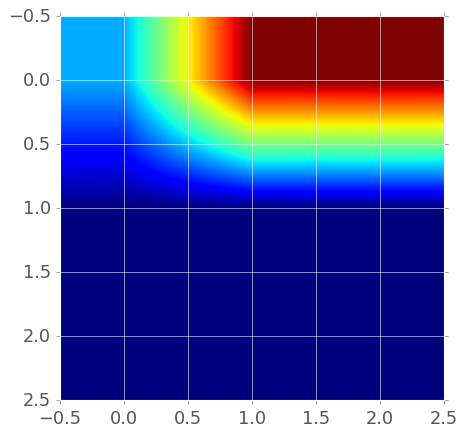

In [132]:
plt.imshow(firstInput.reshape(3,3))

In [552]:
# init_stimulus = setupStimulusAL([], NoNoiseInputs,onAmp=onAmp,signalType=signalType,run_time=50) #reset stimulus each epoch
# drains = [drain_pool[targetClass]]
# initI,initR,initNwState,initSimAL = runSimulations(init_stimulus,None,drains,signalType,run_time=50)

In [122]:
init_stimulus=setupStimulus([], NoNoiseInputs[targetClass],onAmp=0.2,signalType=signalType,run_time=10) #reset stimulus each epoch
initI,initR,initNwState,initSim = runSimulations(init_stimulus,None,drain_pool,signalType,run_time=10)

<Figure size 640x480 with 0 Axes>

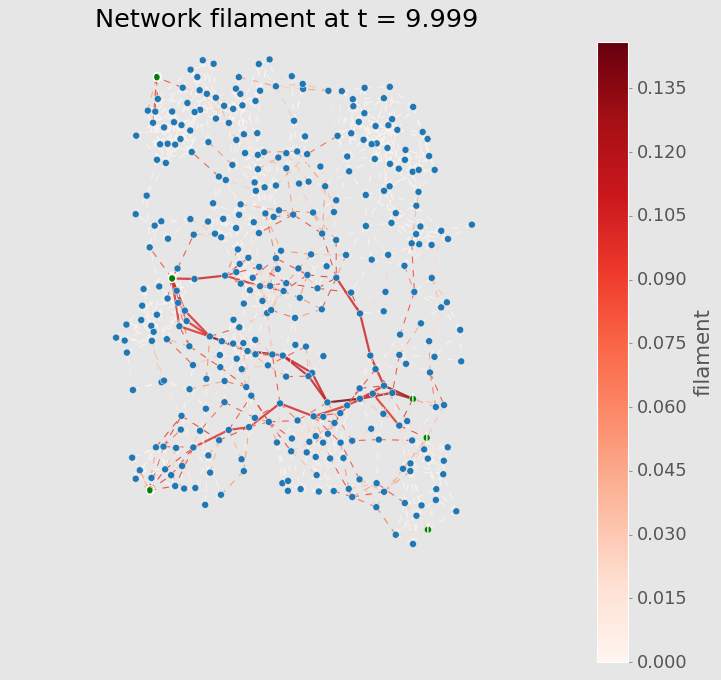

In [123]:
timetoshow=9999
plt.figure()
onSources=np.array(sources)[np.array(NoNoiseInputs[targetClass])>0]
draw_graph(initSim,edge_colorbar=True,edge_mode='filament',this_TimeStamp=timetoshow,node_size=40,node_highlight=list(np.hstack((onSources,drain_pool))),highlight_color='g',with_labels=False)
plt.savefig(saveFig+'row3_10sec_0p2V_filament_states_free_phase.pdf',format='pdf',dpi=300)

Run Training:

In [158]:
# Global Variables
outputs              = {'cost':[],'current':[],'normcurrent':[],'randseed':[],'state':[],'stimulus':[],'target':[],'voltage':[]}
numSamples           = len(trainingInputs) #number of random samples from same class
seed                 = 42 #random seed
epochs               = 50 #number of 'training' to run max, unless we hit 0.1 first
thisNwState          = None #inital network state
network_state        = [[[] for i in range(epochs)] for i in range(numSamples)]
avg_filament_state   = [[[] for i in range(epochs)] for i in range(numSamples)]
maxCurr              = [[[] for i in range(epochs)] for i in range(numSamples)]
np.random.seed(seed)
minCurrent           = 0 #~~ 0 
maxCurrent           = 1e-5 # ~~ 1
onAmp                = 0.1 #amplitude for init
run_time             = 5 # time for each iteration
dt                   = 0.001 #timesteps
signalType           ='DC' #Pulse, DC, AC, Square, Sawtooth
numtraining          = 1 #number of training iterations per epoch
num_drain_training   = 3 #total number of drain electrodes
num_source_training  = len(sources) #total number of source electrodes
onSources            = np.array(sources)[np.array(firstInput)>0]

save_Voltages        = True
trainOrder=np.array(range(numSamples))
np.random.shuffle(trainOrder)

#Run Free Phase:
print('---------- ')
print('Running Free Phase')
print('---------- ')

#USE ADRIAN'S ASSOCIATIVE LEARNING HERE INSTEAD

init_stimulus          = setupStimulus([], firstInput,onAmp=onAmp,signalType=signalType,run_time=run_time) #reset stimulus each epoch
initI,initR,initNwState,initSim = runSimulations(init_stimulus,None,drain_pool,signalType,run_time=run_time)

#Run Weakly Clamped Phase
for sample in tqdm(range(numSamples)): #run 100 random samples from the same class in random order
    
    target_index = np.where(np.array(target_values)==1)[0] #set target class
    val          = trainOrder[sample]#np.random.randint(len(trainingInputs),replace=False) #choose a random training sample
    currInput    = np.array(trainingInputs[val])#[:-1]) #define the input of that training sample
    
    #define which sources are active and which are not (>0 or 0 respectively)
    onSources=np.array(sources)[currInput>0]
    offSources=np.array(sources)[currInput==0]
    
    print('---------- ')
    print('Running Weakly Clamped Phase')
    print('---------- ')
    print('Training #'+str(sample+1))
    print('Training Sample Chosen: '+str(val))
    print('Class ' +str(targetClassVals[targetClass]+1))
    
    if save_Voltages: #if we want to save drain voltages from sample to sample
        if sample == 0: #initalise drain stimulus only for first run, after that we use the stimulus from previous samples
            training_stimulus     = []
            sim_stimulus          = setupStimulus(training_stimulus,currInput,onAmp=onAmp,signalType=signalType,run_time=run_time) #reset stimulus each sample
#         Vinit    = sim_stimulus[:3] #save Vd[0] 
        else: #otherwise we reset the voltages, but keep the network states
            Vd                    = newStimulus[:num_drain_training] #save previous drains
            sim_stimulus          = setupSourcesOnly(Vd,currInput,onAmp=onAmp,run_time=run_time,signalType=signalType) #setup new sources
    else:
        training_stimulus     = []
        sim_stimulus          = setupStimulus(training_stimulus,currInput,onAmp=onAmp,signalType=signalType,run_time=run_time) #reset stimulus each sample

    #define signal 
    signal=[]
    for q in range(num_drain_training):
        signal.append(sim_stimulus[q].signal[0])
    
    print('Drain Voltages '+str(signal))
    print('Source Voltages '+str(currInput))
    print('---------- ')

    
    drainI        = np.zeros((epochs,num_drain_training))
    t             = np.zeros((epochs,num_drain_training))
    cost          = np.zeros((epochs,num_drain_training)) 
    
    #loop through each epoch, i, for sample, "sample"
    
    for i in range(epochs): #for each epoch

        print('Epoch ' + str(i+1))
        if sample == 0 and i == 0: #if we start the first sample and first epoch
            lastNwState=copy.deepcopy(initNwState)
#             thisNwState=None
        elif sample >= 0 and i > 0: #if we move to a new epoch in the current sample
            lastNwState = network_state[sample][i-1] #previous state from previous epoch    
            if lastNwState!=thisNwState:
                print('nw states are not saving properly')
        elif sample > 0 and i==0: #if we move to a new sample that isn't the first sample
            temp=[j for j in network_state[sample-1] if j][-1] #last non empty value in list
            lastNwState = temp #previous state from previous sample        
            if lastNwState!=thisNwState:
                print('nw states are not saving properly')

    
        #run simulation, save currents, resistances, network state and simulation settings
        t[i],v,thisNwState,simulation = runSimulations(sim_stimulus,lastNwState,drain_pool,signalType,run_time=run_time)
        
        avg_filament_state[sample][i]=np.mean(abs(simulation.filamentState),axis=1) #save filament growth
        network_state[sample][i]=thisNwState #save this network state
        
        print('Currents '+str(t[i]))
        
        #normalise currents:
        # take the log, divide everything by reference (see maxCurrent defined at the top of script)
        normT = t[i]/maxCurrent #(t[i]-minCurrent)/(maxCurrent-minCurrent)#(t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])

        if i ==0:
            #normalise thresholds:
            th  = 1 #target threshold range + 0.2
            th2 = minCurrent/maxCurrent #non-target threshold range + 0.2
            
        #change the voltages of target and non-target drains to tune the network into using different pathways
        drainI[i,:],newStimulus,cost[i,:] = change_voltage(sim_stimulus,simulation,normT,target_index,th,th2,signalType)
        
        signal=[]
        for q in range(num_drain_training):
            signal.append(newStimulus[q].signal[0])
        print('New Drain Voltages '+str(signal))
        

        #ENDING EPOCHS

        #using winner-takes-all currents
    
        currents2=np.array(normT)
        thisCostSum = np.sum(cost[i,:])
                
        #(target - non-target1) / target > 0.1
        #(target - non-target2) / target > 0.1 #10% difference 
        # AND acts as argmax
        target=currents2[np.array(target_values)==1]#  target drain curr
        nontarget=currents2[np.array(target_values)==0] # non target drain currs
        sums=[]
        for tar in range(len(target)):
            for nontar in range(len(nontarget)):
                sums.append((target[tar]-nontarget[nontar])/target[tar])
        print(sums)
        if sums[0] > 0.1 and sums[1]>0.1:
            print('Target Currents larger than non-target currents \n')
#             gradOff=True
            break;
        else:
            print('Target Currents smaller than non-target current(s) \n')
#             gradOff=False

        #using total cost less than 0.01:
        
        
#         print('cost ' + str(thisCostSum))
#         if thisCostSum < 0.001:
#             outputs['current'].append(t)
#             outputs['normcurrent'].append(drainI)
#             outputs['cost'].append(cost)
#             outputs['target'].append(target_index)
#             outputs['state'].append(network_state[sample])
#             outputs['randseed']=seed
#             break;
    outputs['current'].append(t)
    outputs['voltage'].append(signal)
    outputs['normcurrent'].append(drainI)
    outputs['cost'].append(cost)
    outputs['target'].append(target_index)
    outputs['state'].append(network_state[sample])
    outputs['randseed']=seed
#     count+=1
    if thisCostSum < 0.005:
        print('Local Minima Found')
        break; #end the loop
#     if (currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][0]))/currents2[target_values==targetClass][0]>=0.99 and (currents2[target_values==targetClass][0]-abs(currents2[target_values!=targetClass][1]))/currents2[target_values==targetClass][0]>=0.99:
#         break;

outputs['stimulus']=newStimulus
    #if total cost is less than 0.02, end training samples
    

#         break;

---------- 
Running Free Phase
---------- 


---------- 
Running Weakly Clamped Phase
---------- 
Training #1
Training Sample Chosen: 1
Class 1
Drain Voltages [0.0, 0.0, 0.0]
Source Voltages [1.         0.91324055 0.86707232 0.         0.         0.
 0.         0.         0.        ]
---------- 
Epoch 1
Currents [1.12840686e-08 9.58037989e-09 5.61777901e-09]
[-1.09871961 -1.09887294 -0.19922958]
[-9.98871593e-02 -9.99041962e-02  5.61777901e-05]
Costs [4.98872230e-01 4.99042421e-01 1.57797205e-07]
Sum Cost 0.997914808516924
Gradients [-1.09871961 -1.09887294 -0.19922958]
New Drain Voltages [-0.07500000000000001, -0.07500000000000001, -0.01992295776143715]
Target Currents larger than non-target currents 

---------- 
Running Weakly Clamped Phase
---------- 
Training #2
Training Sample Chosen: 5
Class 1
Drain Voltages [-0.07500000000000001, -0.07500000000000001, -0.01992295776143715]
Source Voltages [0.15504162 1.         1.         0.         0.         0.
 0.         0.         0.        ]
---------- 
Epoch 1
Currents [ 4.62494980

Analyse Training:

In [160]:
outputs['voltage'][0]

[-0.07500000000000001, -0.07500000000000001, -0.01992295776143715]

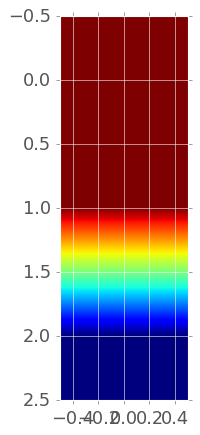

In [161]:
plt.imshow(np.array(target_values).reshape(3,1))

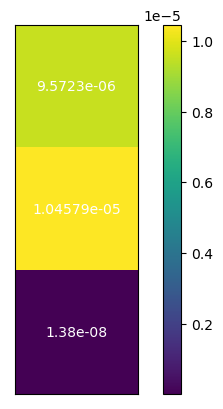

In [164]:
plt.rcParams.update(plt.rcParamsDefault)

plotItem=np.array(outputs['current'][-1][0]).reshape(3,1)

plt.imshow(plotItem)
ax=plt.gca()

for (j,i),label in np.ndenumerate(plotItem):
    ax.text(i,j,np.around(label,10),ha='center',va='center',color='w')
ax.axes.xaxis.set_ticklabels([])
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.yaxis.set_ticks([])
plt.colorbar()

<AxesSubplot:title={'center':'0'}>

<Figure size 640x480 with 0 Axes>

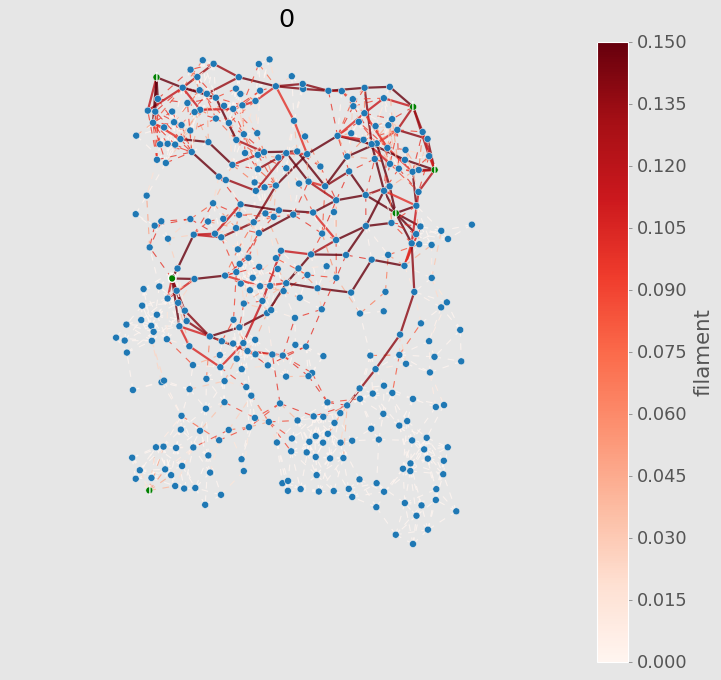

In [166]:
f=plt.figure()
timetoshow=run_time*1000-1
weights= simulation.junctionVoltage[timetoshow,:]*simulation.junctionConductance[timetoshow,:]
vmax = np.max(simulation.junctionVoltage * simulation.junctionConductance)
vmin = np.min(simulation.junctionVoltage * simulation.junctionConductance)

#Draw Currents:
# draw_graph(simulation,edge_colorbar=True,edge_mode='custom',edge_weight=weights,edge_vmax=vmax,edge_vmin=0,this_TimeStamp=timetoshow,node_size=100,node_highlight=drain_pool,with_labels=False)

# Draw Flimanets:
draw_graph(simulation,edge_colorbar=True,edge_mode='filament',this_TimeStamp=timetoshow,node_size=40,node_highlight=list(np.hstack((onSources,drain_pool))),highlight_color='g',with_labels=False,title=str(targetClass))
# plt.savefig(saveFig+'class_v_50samples_10epochs_5sec_0p1V_filament_states_end_training_using_currents.pdf',format='pdf',dpi=300)

In [353]:
mfs=[]
mcon=[]
for i in range(50):
    mfs.append(np.mean(network_state[i][0].filamentState))
    mcon.append(np.mean(network_state[i][0].conductance))

IndexError: list index out of range

ValueError: x and y must have same first dimension, but have shapes (5000,) and (0,)

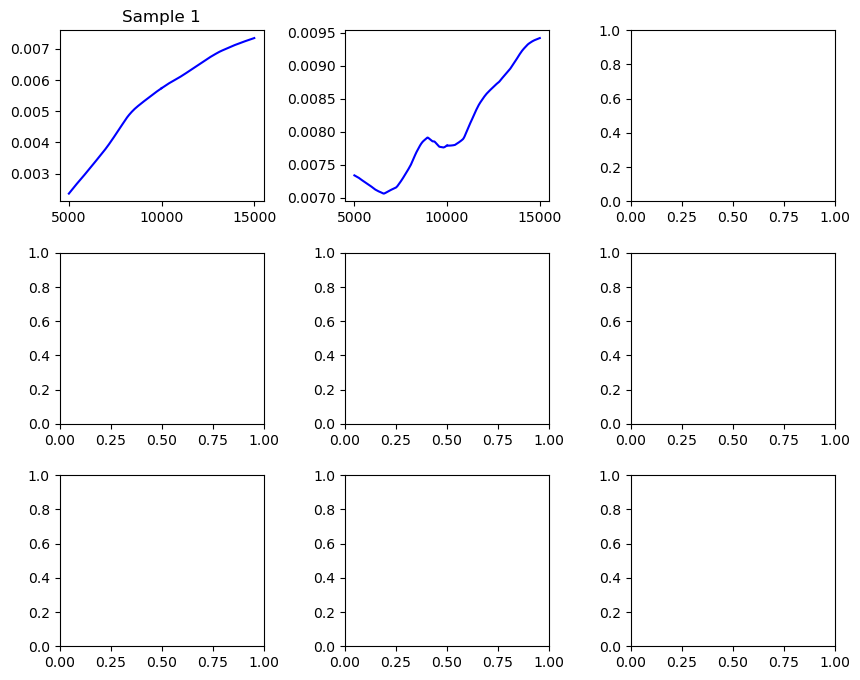

In [354]:
plt.rcParams.update(plt.rcParamsDefault)

f,axes=plt.subplots(3,3,figsize=(10,8))
f.subplots_adjust(hspace=0.3,wspace=0.4)
i=0
for ax in axes.flat:
    ax.plot(range(5000,10000),avg_filament_state[i][0],'b')
    ax.plot(range(10000,15000),avg_filament_state[i][1],'b')
    if i >0:
        ax.plot(range(0,5000),avg_filament_state[i-1][-1],'r')
#     ax.set_ylim([-0.])
    ax.set_title('Sample '+ str(i+1))
    i+=1

In [167]:
#Collate outputs

costs=[];finalCosts=[];
currents=[];finalCurrents=[];normCurrents=[];finalNormCurrents=[]
for i in range(len(outputs['cost'])):
    costs.append(outputs['cost'][i])
    a=np.sum(costs[i],axis=1)!=0
    finalCosts.append(costs[i][np.argwhere(a==True)[0][0]])
    currents.append(outputs['current'][i])
    a2=np.sum(currents[i],axis=1)!=0
    finalCurrents.append(currents[i][np.argwhere(a2==True)[-1][0]])
    normCurrents.append(outputs['normcurrent'][i])
    a3=np.sum(normCurrents[i],axis=1)!=0
    finalNormCurrents.append(normCurrents[i][np.argwhere(a3==True)[-1][0]])

Text(0.5, 0, 'epochs')

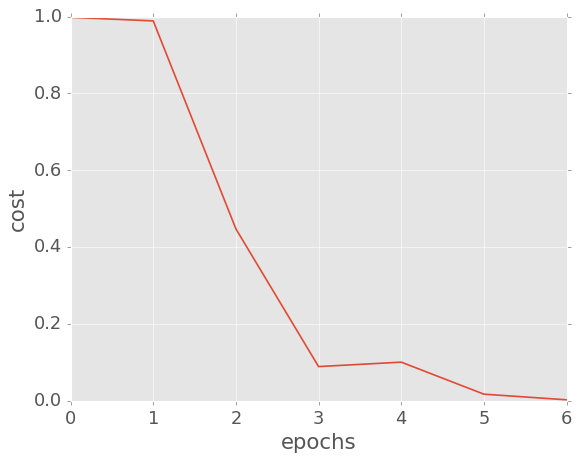

In [168]:
plt.plot(np.sum(finalCosts,axis=1))
plt.ylabel('cost')
plt.xlabel('epochs')
#visualise all epochs + samples (0 to 500)

Text(0.5, 0, 'z | v | n')

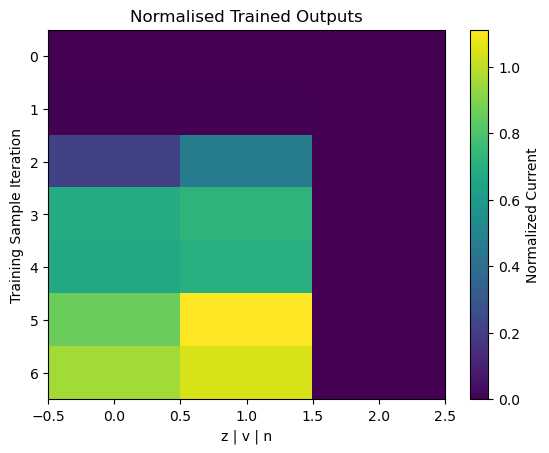

In [169]:
#visualise change in normalised currents across the drains
plt.rcParams.update(plt.rcParamsDefault)

plt.imshow(finalNormCurrents,aspect='auto')
plt.colorbar(label='Normalized Current')
plt.title('Normalised Trained Outputs')
plt.ylabel('Training Sample Iteration')
plt.xlabel('z | v | n')

Text(0.5, 0, 'z | v | n')

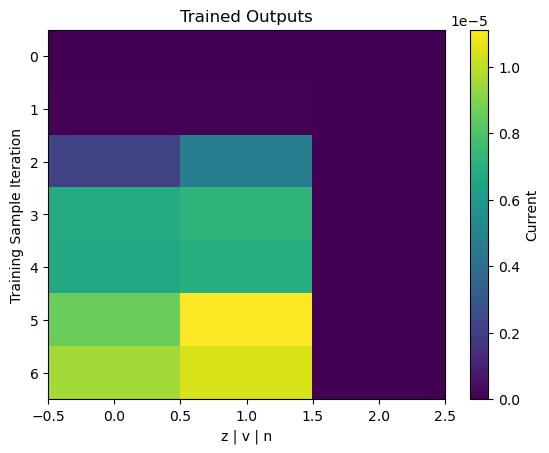

In [170]:
#visualise change in actual currents across the drains as a function of training samples

plt.imshow(finalCurrents,aspect='auto')
plt.colorbar(label='Current')
plt.title('Trained Outputs')
plt.ylabel('Training Sample Iteration')
plt.xlabel('z | v | n')

In [171]:
data=pd.DataFrame(np.array([finalCosts,finalCurrents,outputs['target']]).T)

In [172]:
maxCurrentsIdx=[]
for i in range(len(data[1])):
    maxCurrentsIdx.append(np.argmax(data[1][i]))

## Testing

In [173]:
new_states=[]
for i in range(len(network_state)):
    for j in range(len(network_state[i])):
        if network_state[i][j]:
            new_states.append(network_state[i][j])

In [175]:
# RUN TESTING WITH NEW DATA:

#Global Variables
numClasses          = 3

costSV              = [[] for i in range(numClasses)]
costS               = [[] for i in range(numClasses)]
costV               = [[] for i in range(numClasses)]
costNone            = [[] for i in range(numClasses)]

numTestingSamples   = len(testingInputs)
seed                = 42 #random seed
thisNwState         = None #inital network state
np.random.seed(seed)
network_state_train = new_states[-1]#[i for i in network_state[-1] if i][-1] #last network state after training
network_state_test  = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
simtest             = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
trained             = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
allSources          = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
maxCurr             = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
stimulus_train      = copy.deepcopy(sim_stimulus)
#KEEP DRAIN VOLTAGES
drain_voltages      = False
use_network_state   = True

# targetClass = 2
for inputClass in tqdm(range(numClasses)): #for each class, z, v, n 
    for sample in (range(numTestingSamples)): #for each test sample
        #target_index = int(targets[targets==targetClassVals[targetClass]][sample]) #set target index
        if inputClass == targetClass: #if the class we're inputting is the target class
            currTest     =  testingInputs[sample]#[:-1] #choose test sample inputs for desired class
        else:
            currTest     =  inputs[inputClass][2:][sample]#inputs[targets==targetClassVals[inputClass]][sample][:-1]#inputs[inputClass][2:][sample] #choose test sample inputs for other classes       

        onSources=np.array(sources)[np.array(currTest)>0]
        allSources[inputClass][sample]=onSources
        offSources=np.array(sources)[np.array(currTest)==0]
            
        print('---------- ')
        print('Class ' +str(inputClass))
        print('Test Sample ' +str(sample+1))

        epochs       = 1 #number of 'test' to run max, unless we hit 0.1 first
        onAmp        = 0.1 #amplitude for init
        run_time     = 5 # time for each iteration
        dt           = 0.001 #timesteps

        signalType   ='DC' #Pulse, DC, AC, Square, Sawtooth

        numtesting             = 1 #number of training iterations per epoch
        num_drain_testing      = 3 #total number of drain electrodes
        num_source_testing     = len(sources) #total number of source electrodes
        ttest                  = np.zeros((epochs,num_drain_testing))
        testing_stimulus       = []
           
        
        if drain_voltages: #if we keep drain_voltages from last training epoch
            testing_drain_stimulus = copy.deepcopy(stimulus_train[:num_drain_testing])
            for i in range(len(testing_drain_stimulus)):
                testing_drain_stimulus[i].signal=np.hstack([testing_drain_stimulus[i].signal])#*10)
            testing_stimulus       = setupSourcesOnly(testing_drain_stimulus,currTest,run_time=run_time,onAmp=onAmp)
            
        else: #if we reset drain voltages to 0, and just use network state in runSimulations
            testing_stimulus       = setupStimulus(testing_stimulus,currTest,onAmp=onAmp,signalType=signalType,run_time=run_time)

        print('Drain Voltages '+str([testing_stimulus[0].signal[0],testing_stimulus[1].signal[0],testing_stimulus[2].signal[0]]))
        print('Source Voltages '+str([k.signal[0] for k in testing_stimulus][num_drain_testing:]))
        
        for i in range(epochs): #for each epoch
            if use_network_state:
                thisNwState = copy.deepcopy(network_state_train) #final state from training
            else:
                thisNwState = None

            #run training + change voltages - save network state after each epoch.
            ttest[i],r,network_state_test[inputClass][sample],simtest[inputClass][sample] = runSimulations(testing_stimulus,thisNwState,drain_pool,signalType,run_time=run_time)
            
            print('Currents '+str(ttest[i]))
            print('Voltages '+str(simtest[inputClass][sample].wireVoltage.T[drain_pool].T[0]))

            #normalise currents:
            normCurr = ttest[i]/maxCurrent#(t[i]-minCurrent)/(maxCurrent-minCurrent)#(t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
#         set_trace()
            if i ==0:
            #normalise thresholds:
                th  = 1 #target threshold range + 0.2
                th2 = minCurrent/maxCurrent #non-target threshold range + 0.2

            #calculate output currents of drains after each epoch
            #change the voltages of target and non-target drains to tune the network into using different pathways
           
            currents2=np.array(normCurr)
            maxCurr[inputClass][sample]=np.argmax(currents2)
            vals=currents2[np.array(target_values)==1]-abs(currents2[np.array(target_values)==0])/currents2[np.array(target_values)==1]
            print(vals)
            if vals[0]>0.5 or vals[1]>0.5:
                trained[inputClass][sample]=True
            else:
                trained[inputClass][sample]=False
        
            if use_network_state and drain_voltages:
                print('nw state and voltage')
                costSV[inputClass].append(runTesting(normCurr,th,th2))
            elif use_network_state and not drain_voltages:
                print('nw state and no voltage')
                costS[inputClass].append(runTesting(normCurr,th,th2))
            elif not use_network_state and drain_voltages:
                print('no nw state and voltage')
                costV[inputClass].append(runTesting(normCurr,th,th2))
            else:  
                print('no nw state and no voltage')
                costNone[inputClass].append(runTesting(normCurr,th,th2))      

#              cost2=np.array(cost[i,:])
#         if cost2[target_values==targetClass][0]<cost2[target_values!=targetClass][0] or cost2[target_values==targetClass][0]<cost2[target_values!=targetClass][1]:
#             print('Target Cost lower than 1 non-target cost\n')
#             break;
#         else:
#             print('Target Cost not lower than 1 non-target cost\n')
            
            
            

---------- 
Class 0
Test Sample 1
Drain Voltages [0.0, 0.0, 0.0]
Source Voltages [0.08278690037875887, 0.1, 0.1]
Currents [5.52395635e-06 6.72346983e-06 9.17249367e-09]
Voltages [0. 0. 0.]
[0.55073514 0.67098273]
nw state and no voltage
---------- 
Class 0
Test Sample 2
Drain Voltages [0.0, 0.0, 0.0]
Source Voltages [0.0085347464993768, 0.1, 0.00516817211686077]
Currents [2.56933293e-06 2.19537702e-06 2.48106702e-09]
Voltages [0. 0. 0.]
[0.25596765 0.21840757]
nw state and no voltage
---------- 
Class 1
Test Sample 1
Drain Voltages [0.0, 0.0, 0.0]
Source Voltages [0.1, 0.1, 0.043352073758074205]
Currents [3.05038564e-06 4.46862284e-06 6.81159354e-09]
Voltages [0. 0. 0.]
[0.30280554 0.44533797]
nw state and no voltage
---------- 
Class 1
Test Sample 2
Drain Voltages [0.0, 0.0, 0.0]
Source Voltages [0.1, 0.09626484146779252, 0.0025350743415457513]
Currents [3.02839769e-06 4.40838055e-06 6.53708219e-09]
Voltages [0. 0. 0.]
[0.30068117 0.43935518]
nw state and no voltage
---------- 
Class 

Analyse Testing:

In [176]:
trained

[[True, False], [False, False], [False, False]]

In [177]:
maxCurr

[[1, 0], [1, 1], [1, 1]]

In [392]:
# fig,axes=plt.subplots(3,2,figsize=(15,15))
# timetoshow=run_time*1000-1

# for i in range(len(simtest)):
#     for j in range(len(simtest[i])):
#         ax=axes[i][j]
#         weights= simtest[i][j].junctionVoltage[timetoshow,:]*simtest[i][j].junctionConductance[timetoshow,:]
#         vmax = 1e-5#np.max(simtest[i][j].junctionVoltage * simtest[i][j].junctionConductance)
#         vmin = -1e-5#np.min(simtest[i][j].junctionVoltage * simtest[i][j].junctionConductance)
#         draw_graph(simtest[i][j],edge_colorbar=True,edge_mode='custom',edge_weight=np.log(weights),this_TimeStamp=timetoshow,node_size=20,node_highlight=np.hstack((allSources[i][j],drain_pool)),highlight_color='g',ax=ax,with_labels=False)        
# #         draw_graph(simtest[i][j],edge_colorbar=True,edge_mode='filament',this_TimeStamp=timetoshow,node_size=10,node_highlight=list(np.hstack((allSources[i][j],drain_pool))),highlight_color='g',with_labels=False,title=target_letters[i],ax=ax)

# plt.savefig(saveFig+'class_v_currents_after_5sec_testing_using_currents_nwstate.pdf',format='pdf',dpi=300)
# # plt.savefig(saveFig+'class_v_filament_states_after_10sec_testing_using_currents_nwstate.pdf',format='pdf',dpi=300)

In [178]:
# costs=pd.DataFrame({'z':{'state':np.sum(costS[0],axis=1),'voltage':np.sum(costV[0],axis=1),'voltage_and_state':np.sum(costSV[0],axis=1)},'v':{'state':np.sum(costS[1],axis=1),'voltage':np.sum(costV[1],axis=1),'voltage_and_state':np.sum(costSV[1],axis=1)},'n':{'state':np.sum(costS[2],axis=1),'voltage':np.sum(costV[2],axis=1),'voltage_and_state':np.sum(costSV[2],axis=1)}})

In [179]:
# dfV=pd.DataFrame([['z',costs['z']['voltage'][0],costs['z']['voltage'][1]],['v',costs['v']['voltage'][0],costs['v']['voltage'][1]],['n',costs['n']['voltage'][0],costs['n']['voltage'][1]]],columns=['Class','Test Sample 1','Test Sample 2'])
# dfSV=pd.DataFrame([['z',costs['z']['voltage_and_state'][0],costs['z']['voltage_and_state'][1]],['v',costs['v']['voltage_and_state'][0],costs['v']['voltage_and_state'][1]],['n',costs['n']['voltage_and_state'][0],costs['n']['voltage_and_state'][1]]],columns=['Class','Test Sample 1','Test Sample 2'])
# dfS=pd.DataFrame([['z',costs['z']['state'][0],costs['z']['state'][1]],['v',costs['v']['state'][0],costs['v']['state'][1]],['n',costs['n']['state'][0],costs['n']['state'][1]]],columns=['Class','Test Sample 1','Test Sample 2'])

In [180]:
dfS=pd.DataFrame([['1',np.sum(costS[0],axis=1)[0],np.sum(costS[0],axis=1)[1]],['2',np.sum(costS[1],axis=1)[0],np.sum(costS[1],axis=1)[1]],['3',np.sum(costS[2],axis=1)[0],np.sum(costS[2],axis=1)[1]]],columns=['Class','Test Sample 1','Test Sample 2'])

<AxesSubplot:title={'center':'NW State'}, xlabel='Class', ylabel='cost'>

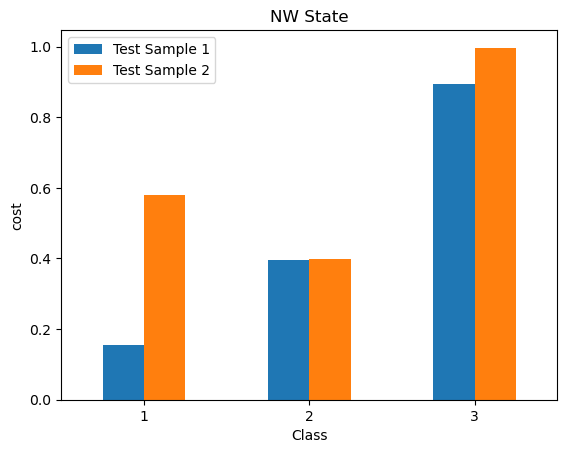

In [181]:
# dfV.plot(x='Class', kind='bar', stacked=False,ylabel='cost',rot=0,title='Voltages Only')
# dfSV.plot(x='Class', kind='bar', stacked=False,ylabel='cost',rot=0,title='Voltages and NW State')
dfS.plot(x='Class', kind='bar', stacked=False,ylabel='cost',rot=0,title='NW State')

In [464]:
# # Testing using number of epochs  to get to minima:
# #Run Weakly Clamped Phase
# import copy
# epochs              = 10
# numClasses          = 3
# numTestingSamples   = len(testingInputs)
# seed                = 42 #random seed
# thisNwState         = None #inital network state
# np.random.seed(seed)
# network_state_train = [i for i in network_state[-1] if i][-1] #last network state after training
# numEpochsForTesting = []
# stimulus_train = copy.deepcopy(sim_stimulus)
# print('Training Voltages '+str([stimulus_train[0].signal[0],stimulus_train[1].signal[0],stimulus_train[2].signal[0]]))
# for inputClass in tqdm(range(numClasses)): #for each class, z, v, n 
#     for sample in tqdm(range(numTestingSamples)): #run 100 random samples from the same class in random order
    
#         target_index = int(targetClassVals[targetClass-1]) #set target class    

#         if inputClass == targetClass: #if the class we're inputting is the target class
#             currTest     =  testingInputs[sample][:-1] #choose test sample inputs for desired class
#         else:
#             currTest     =  inputs[targets==inputClass][sample][:-1] #choose test sample inputs for other classes       

#         onSources=np.array(sources)[currTest>0]
#         offSources=np.array(sources)[currTest==0]
        
#         print('---------- ')
#         print('Class ' +str(target_letters[inputClass]))
#         print('Test Sample ' +str(sample+1))

#         testing_drain_stimulus  = copy.deepcopy(stimulus_train[:3])
#         test_sim_stimulus       = setupSourcesOnly(testing_drain_stimulus,currTest,onAmp)

#         print('Drain Voltages '+str([test_sim_stimulus[0].signal[0],test_sim_stimulus[1].signal[0],test_sim_stimulus[2].signal[0]]))
#         print('Source Voltages '+str(currTest))
#         print('---------- ')


#         currents          = np.zeros((epochs,num_drain_training))
#         testCost          = np.zeros((epochs,num_drain_training)) 

#         for i in range(epochs): #for each epoch

#             print('Epoch ' + str(i+1))
#             #copy last state
#             if i == 0: #if we start the first sample and first epoch
#                 lastNwState=copy.deepcopy(network_state_train)
#                 print(np.sum(lastNwState.conductance!=network_state_train.conductance))
#             else:
#                 lastNwState=copy.deepcopy(thisNwState)
#                 print(np.sum(lastNwState.conductance!=network_state_train.conductance))
#             #copy last epoch stimulus     
#             if i > 0:
#                 test_sim_stimulus=newStimulus
                
#             #run simulation, save currents, resistances, network state and simulation settings
#             currents[i],v,thisNwState,simtest = runSimulations(test_sim_stimulus,lastNwState,signalType,run_time=run_time)

#             print('Currents '+str(currents[i]))
#             #normalise currents:
#             # take the log, divide everything by reference, i ~= 1e-8 (arbitrary)

#             normT = currents[i]/maxCurrent#(t[i]-minCurrent)/(maxCurrent-minCurrent)#(t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
#     #         set_trace()
#             if i ==0:
#                 #normalise thresholds:
#                 th  = 1 #target threshold range + 0.2
#                 th2 = minCurrent/maxCurrent #non-target threshold range + 0.2

#             #change the voltages of target and non-target drains to tune the network into using different pathways
#             drainCurrs,newStimulus,testCost[i,:] = change_voltage(test_sim_stimulus,simtest,normT,target_index,th,th2,signalType)
#             print('New Drain Voltages '+str([newStimulus[0].signal[0],newStimulus[1].signal[0],newStimulus[2].signal[0]]))

#             #if total cost is less than 0.02, end epochs for training sample
#             thisCostSum = np.sum(testCost[i,:])
#             if thisCostSum < 0.01:
#                 print('minima found for current sample')
#     #             outputs['current'].append(t)
#     #             outputs['normcurrent'].append(drainI)
#     #             outputs['cost'].append(cost)
#     #             outputs['target'].append(target_index)
#     #             outputs['state'].append(network_state[sample])
#     #             outputs['randseed']=seed
#                 numEpochsForTesting.append(i)
#                 break;
#             if thisCostSum > 0.01 and i==epochs-1:
#                 numEpochsForTesting.append(i)

In [572]:
targetClass

1

In [328]:
numEpochsForTesting

[0, 0, 0, 0, 0, 0]

### old code

In [316]:
currTest

array([1.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.04645041])

In [ ]:
# #Global Variables
# outputs={'cost':[],'current':[],'normcurrent':[],'state':[],'target':[]}
# count=0
# for target_index in tqdm(targets):
#     currInput=inputs[count][:-1]
#     target_index=int(target_index)
    
#     epochs=35 #number of 'training' to run
#     onAmp_init = 1 #amplitude for init
#     init_runTime=5 #duration of init signal
#     run_time = 1 # time for each iteration
#     dt = 0.001 #timesteps
#     numinit = 1 #number of times we initialise network pathways
#     signalType='DC' #Pulse, DC, AC, Square, Sawtooth

#     num_drain_init = 1 #number of drains for init simulation
#     num_source_init = len(sources) #number of sources

#     numtraining = 1 #number of training iterations per epoch
#     num_drain_training = 3 #total number of drain electrodes
#     num_source_training = len(sources) #total number of source electrodes
#     training_stimulus = []

#     #Run inital associative learning (akin to letting the network get to equilibrium)
#     sim1_stimulus=init(sources,onAmp_init,init_runTime,currInput,signalType)

#     #Save network state after this
#     sim1,JS0=getInitState(sim1_stimulus,sources,drain_pool,target_index,count)

#     #Set up the first instance of the training stimulus
#     sim2_stimulus=setupStimulus(training_stimulus,currInput,onAmp_init,signalType)

#     drainI=np.zeros((epochs,num_drain_training))
#     t=np.zeros((epochs,num_drain_training))
#     cost=np.zeros((epochs,num_drain_training)) 
#     print('---------- ')
#     print('Training Sample #'+str(count+1))
#     print('Target ' +str(target_index))
#     for i in range(epochs): #for each epoch
# #     i=0
# #     thisCostSum=1
# #     while thisCostSum>0.1: #repeat until cost is less than 0.1
#         print('Epoch ' + str(i))
#         #run training + change voltages - save network state after each epoch.
#         t[i],r,network_state,sim2=runSimulations(sim2_stimulus,JS0,signalType)
#         #normalised currents:
#         normT=(t[i]-np.mean(t[i]))/np.std(t[i])
# #         set_trace()
#         #define threshold (+- 3 orders of magnitude):
#         if i ==0:
#             #normalised thresholds:
#             th  =  1 #t[2]/ThresholdOrderMagnitudes #target threshold 
#             th2 = -1 #np.mean(t[0:2])*ThresholdOrderMagnitudes #non-target threshold 
#         #calculate output currents of drains after each epoch
#         #change the voltages of target and non-target drains to tune the network into using different pathways
#         drainI[i,:],sim2_stimulus,cost[i,:]=runAssLearning2(sim2_stimulus,sim2,normT,r,target_index,th,th2,signalType,)    
# #         thisCostSum=np.sum(cost[i,:])
# #         i+=1z
        
#     outputs['current'].append(t)
#     outputs['normcurrent'].append(drainI)
#     outputs['cost'].append(cost)
#     outputs['target'].append(target_index)
#     outputs['state'].append(network_state)
#     count+=1

In [ ]:
# #Global Variables
# outputs          = {'cost':[],'current':[],'normcurrent':[],'randseed':[],'state':[],'target':[]}
# # count            = 0
# numSamples       = 100 #number of random samples from same class
# seed             = 42 #random seed
# epochs       = 10 #number of 'training' to run max, unless we hit 0.1 first
# thisNwState      = None #inital network state
# network_state    = [[[None] for i in range(epochs)] for i in range(numSamples)]

# np.random.seed(seed)

# for sample in tqdm(range(numSamples)): #run 100 random samples from the same class in random order
    
#     target_index = targets[targetClass] #set target class
#     val          = np.random.randint(len(trainingInputs)) #choose a random training sample
#     currInput    = trainingInputs[val][:-1] #define the input of that training sample
# #     currInput    = inputs[val][:-1]
#     target_index = int(target_index)
    
#     print('---------- ')
#     print('Training #'+str(sample+1))
#     print('Training Sample Chosen: '+str(val))
#     print('Class ' +str(target_letters[target_index]))
    
#     onAmp        = 1 #amplitude for init
# #     init_runTime = 5 #duration of init signal
#     run_time     = 2 # time for each iteration
#     dt           = 0.001 #timesteps
# #     numinit = 1 #number of times we initialise network pathways
#     signalType   ='DC' #Pulse, DC, AC, Square, Sawtooth

# #     num_drain_init = 1 #number of drains for init simulation
# #     num_source_init = len(sources) #number of sources
#     #Set up the first instance of the training stimulus
#     numtraining         = 1 #number of training iterations per epoch
#     num_drain_training  = 3 #total number of drain electrodes
#     num_source_training = len(sources) #total number of source electrodes
#     training_stimulus   = []
#     if sample == 0: #initalise drain stimulus only for first run, after that we use the stimulus from previous samples
#         print('No Inital Stimulus, Saving New Stimulus')
#     else:
#         training_drain_stimulus    = sim2_stimulus[:3] #save previous drains
#         training_stimulus          = setupSourcesOnly(training_drain_stimulus,currInput,onAmp,signalType) #setup new sources
#     print('Source Voltages '+str(currInput))
#     print('---------- ')
# #     #Run inital associative learning (akin to letting the network get to equilibrium)
# #     sim1_stimulus=init(sources,onAmp_init,init_runTime,currInput,signalType)

# #     #Save network state after this
# #     sim1,JS0=getInitState(sim1_stimulus,sources,drain_pool,target_index,count)

#     drainI        = np.zeros((epochs,num_drain_training))
#     t             = np.zeros((epochs,num_drain_training))
#     cost          = np.zeros((epochs,num_drain_training)) 
    
#     for i in range(epochs): #for each epoch

#         print('Epoch ' + str(i))

#         if sample == 0 and i == 0: #if we start the first sample and first epoch
#             print('No Inital Network State, Saving New State')
#         elif sample > 0 and i==0: #if we move to a new sample that isn't the first sample
#             thisNwState = network_state[sample-1][-1] #previous state from previous sample
#         elif sample >= 0 and i > 0: #if we move to a new epoch in the current sample
#             thisNwState = network_state[sample][i-1] #previous state from previous epoch 
#             #need to save for each epoch as well
#             #currently starting at same initial state, different voltages, but we want to save the state
#         #run training + change voltages - save network state after each epoch.

#         t[i],r,network_state[sample][i],sim2 = runSimulations(sim2_stimulus,thisNwState,signalType)
        
#         print('Currents '+str(t[i]))
#         print('Drain Voltages '+str(sim2.wireVoltage.T[drain_pool].T[0]))

#         #normalise currents:
#         normT = (t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
        
#         if i ==0:
#             #normalise thresholds:
#             th  = 1 #target threshold range + 0.2
#             th2 = 0 #non-target threshold range + 0.2
            
#         #calculate output currents of drains after each epoch
#         #change the voltages of target and non-target drains to tune the network into using different pathways
#         drainI[i,:],sim2_stimulus,cost[i,:] = runAssLearning2(sim2_stimulus,sim2,normT,r,target_index,th,th2,signalType)    
        
#         #if total cost is less than 0.02, end epochs for training sample
#         thisCostSum = np.sum(cost[i,:])
#         if thisCostSum < 0.02:
#             break;
    
#     outputs['current'].append(t)
#     outputs['normcurrent'].append(drainI)
#     outputs['cost'].append(cost)
#     outputs['target'].append(target_index)
#     outputs['state'].append(network_state[sample])
#     outputs['randseed']=seed
# #     count+=1

#     #if total cost is less than 0.02, end training samples
#     if thisCostSum < 0.02:
#         print('Global Minima Found')
#         break;